# Analyzing fluent dependencies and evaluation order.

In this advanced notebook, we analyze the dependencies between fluents and evaluate their order of evaluation.

First install the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet --upgrade networkx
%pip install --quiet pyRDDLGym rddlrepository

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt
import networkx as nx

import pyRDDLGym
from pyRDDLGym.core.compiler.levels import RDDLLevelAnalysis

We will study the dependencies between fluents in the Elevators domain:

In [3]:
env = pyRDDLGym.make('Elevators', '0')

C:\Python\envs\rddl\Lib\site-packages\pyRDDLGym\core\debug\exception.py:28: UserWarning: State invariant 1 does not have a structure of <action or state fluent> <op> <rhs>, where <op> is one of {<=, <, >=, >} and <rhs> is a deterministic function of non-fluents only, and will be ignored.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(message)


Now, let us construct a call graph for the current problem using the ``RDDLLevelAnalysis`` object:

In [4]:
level_analysis = RDDLLevelAnalysis(env.model)
graph = level_analysis.build_call_graph()
for key, value in graph.items():
    print(f'{key}: {value}')

num-arrival: []
num-get-on-elevator: ['elevator-at-floor', 'elevator-closed', 'elevator-dir-up', 'num-person-waiting']
num-person-waiting': ['elevator-at-floor', 'elevator-closed', 'num-arrival', 'num-person-waiting']
num-person-in-elevator': ['elevator-at-floor', 'num-get-on-elevator', 'num-person-in-elevator']
elevator-closed': ['close-door', 'elevator-at-floor', 'elevator-closed', 'open-door']
elevator-dir-up': ['elevator-at-floor', 'elevator-dir-up', 'open-door']
elevator-at-floor': ['close-door', 'elevator-at-floor', 'elevator-closed', 'elevator-dir-up', 'move-current-dir', 'open-door']


Let us plot this using the networkx package to better visualize the dependencies. We will make action-fluents red, state-fluents blue, and interm-fluents gray:

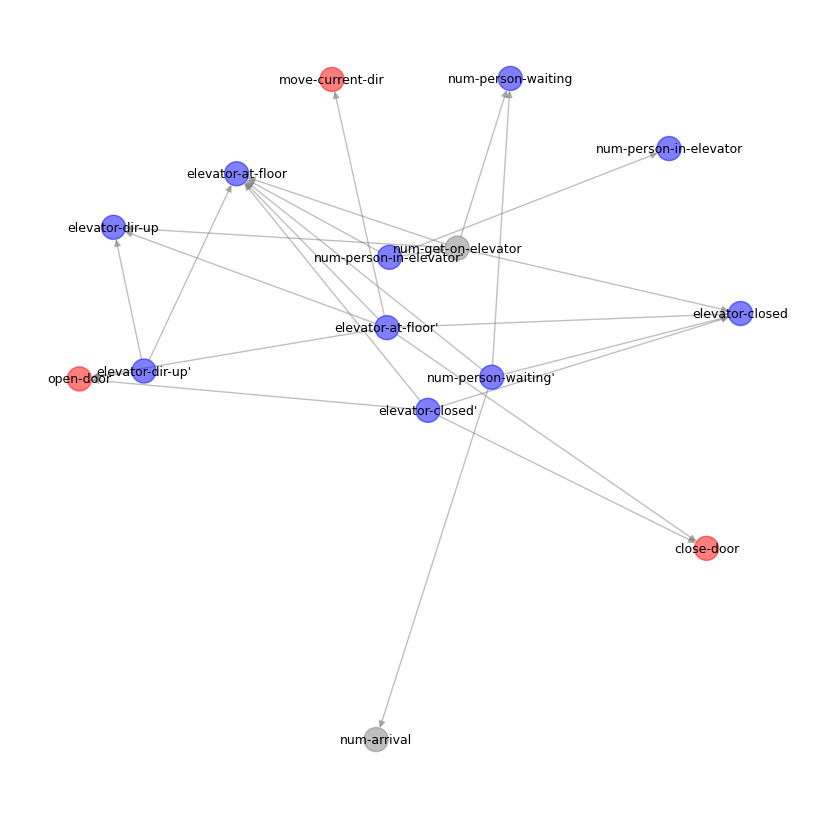

In [5]:
G = nx.DiGraph(directed=True)
G.add_edges_from([(key, value) for key, values in graph.items() for value in values])
color_map = []
for node in G:
    if node in env.model.action_fluents:   
        color_map.append('red')
    elif node in env.model.interm_fluents: 
        color_map.append('gray')
    else:                                  
        color_map.append('blue')
pos = nx.spring_layout(G, scale=50, k=0.9)
plt.figure(figsize=(8, 8)) 
nx.draw(G, pos, edge_color='gray', node_color=color_map, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)
%matplotlib inline
plt.show()

Finally, we can also determine the correct order of evaluation of the fluents:

In [6]:
order = level_analysis.compute_levels()
for level, value in order.items():
    print(f'level {level} : {value}')

level 0 : ["elevator-at-floor'", "elevator-closed'", "elevator-dir-up'", 'num-arrival', 'num-get-on-elevator']
level 1 : ["num-person-in-elevator'", "num-person-waiting'"]


This means that the fluents listed at level 0 should be evaluated first in any order since they don't depend on each other, and then the fluents in level 1 should be computed. 